## Recommendation Approach

This system uses **User-Based Collaborative Filtering**.
Artists are recommended based on listening behavior of users
with similar taste, measured using cosine similarity.


In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [254]:
user_artists = pd.read_csv("user_artists.dat", sep="\t")
artists = pd.read_csv("artists.dat", sep="\t")

In [255]:
print(user_artists.head())

   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983


In [256]:
print(user_artists.shape, artists.shape)

(92834, 3) (17632, 4)


In [257]:
print("Rows:", user_artists.shape[0])
print("Columns:", user_artists.shape[1])

Rows: 92834
Columns: 3


In [258]:
user_artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB


In [259]:
user_artists['weight'].describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

In [260]:
user_artists.isna().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [261]:
user_artists.duplicated().sum()

0

In [262]:
user_artists = user_artists.drop_duplicates()

In [263]:
print(f"Users: {user_artists['userID'].nunique()}")
print(f"Artists: {user_artists['artistID'].nunique()}")
print(f"Interactions: {len(user_artists)}")

Users: 1892
Artists: 17632
Interactions: 92834


In [264]:
user_artist_matrix = user_artists.pivot_table(
    index='userID',
    columns='artistID',
    values='weight',
    fill_value=0
)

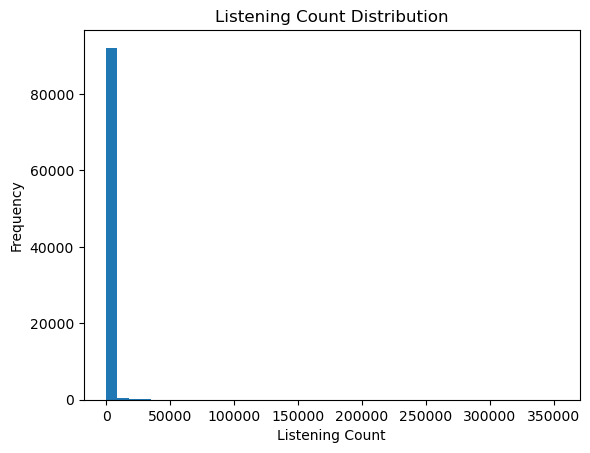

In [265]:
plt.hist(user_artists['weight'], bins=40)
plt.xlabel("Listening Count")
plt.ylabel("Frequency")
plt.title("Listening Count Distribution")
plt.show()

In [266]:
top_artists = (
    user_artists.groupby('artistID')['weight']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_artists

artistID
289    2393140
72     1301308
89     1291387
292    1058405
498     963449
67      921198
288     905423
701     688529
227     662116
300     532545
Name: weight, dtype: int64

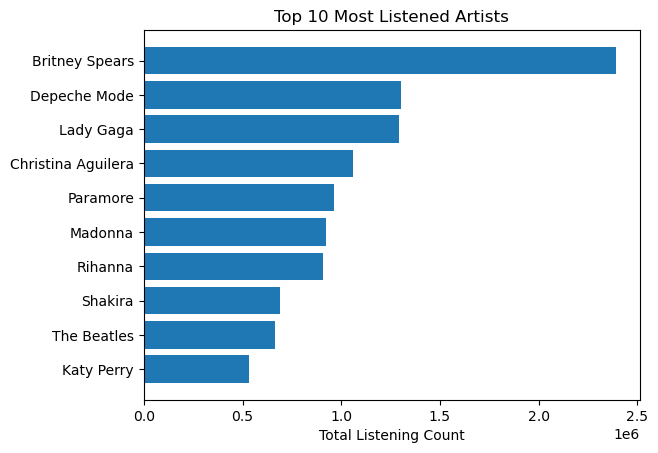

In [267]:
top_named = artists.merge(top_artists, left_on='id', right_index=True)
top_named = top_named.sort_values('weight')

plt.barh(top_named['name'], top_named['weight'])
plt.title("Top 10 Most Listened Artists")
plt.xlabel("Total Listening Count")
plt.show()


In [268]:
artists.merge(
    top_artists,
    left_on='id',
    right_index=True
)[['name', 'weight']]


,name,weight
61,Madonna,921198
66,Depeche Mode,1301308
83,Lady Gaga,1291387
221,The Beatles,662116
282,Rihanna,905423
283,Britney Spears,2393140
286,Christina Aguilera,1058405
294,Katy Perry,532545
492,Paramore,963449
695,Shakira,688529


In [269]:
user_activity = user_artists.groupby('userID')['artistID'].count()

user_activity.describe()

count    1892.000000
mean       49.066596
std         5.845879
min         1.000000
25%        50.000000
50%        50.000000
75%        50.000000
max        50.000000
Name: artistID, dtype: float64

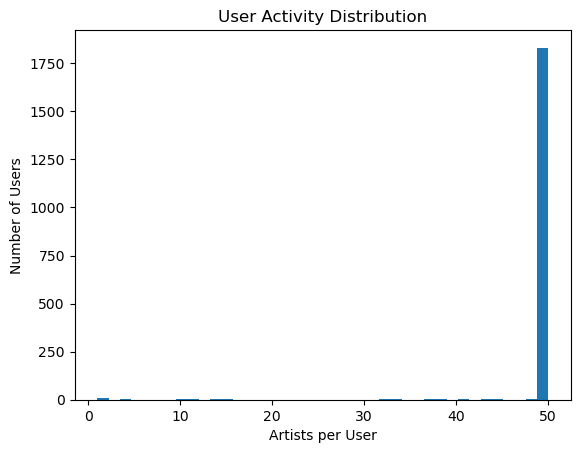

In [270]:
plt.hist(user_activity, bins=40)
plt.xlabel("Artists per User")
plt.ylabel("Number of Users")
plt.title("User Activity Distribution")
plt.show()

In [271]:
artist_popularity = user_artists.groupby('artistID')['userID'].count()

artist_popularity.describe()

count    17632.000000
mean         5.265086
std         20.620315
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        611.000000
Name: userID, dtype: float64

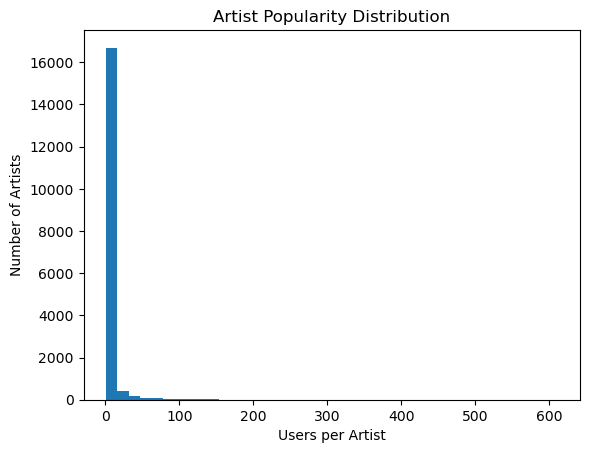

In [272]:
plt.hist(artist_popularity, bins=40)
plt.xlabel("Users per Artist")
plt.ylabel("Number of Artists")
plt.title("Artist Popularity Distribution")
plt.show()

In [273]:
user_activity.quantile([0.25, 0.5, 0.75, 0.9])

0.25    50.0
0.50    50.0
0.75    50.0
0.90    50.0
Name: artistID, dtype: float64

In [274]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_artist_matrix, dense_output=False)

user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_artist_matrix.index,
    columns=user_artist_matrix.index
)


In [275]:
def recommend_artists(user_id, n_recommendations=5):
    similar_users = (
        user_similarity_df[user_id]
        .sort_values(ascending=False)
        .iloc[1:6]  
    )

    scores = user_artist_matrix.loc[similar_users.index].T.dot(similar_users)

    already_listened = user_artist_matrix.loc[user_id]
    scores = scores[already_listened == 0]

    return scores.sort_values(ascending=False).head(n_recommendations)


In [276]:
recommend_artists(2)

artistID
159     8054.686401
511     6978.195244
1001    6896.275902
2562    6028.143284
1014    4748.164071
dtype: float64

In [277]:
def show_artist_names(artist_ids):
    return artists[artists['id'].isin(artist_ids)][['id', 'name']]

recs = recommend_artists(2)
show_artist_names(recs.index)


,id,name
153,159,The Cure
505,511,U2
992,1001,Pet Shop Boys
1005,1014,Erasure
2542,2562,Arcadia


## Conclusion

I built a user-based collaborative filtering recommendation system
using Last.fm listening data. Due to high sparsity and user behavior
patterns, similarity-based methods are effective. This approach can
be extended using item-based or model-based techniques.